In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pytesseract
from PIL import Image, ImageDraw

pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/Cellar/tesseract/5.3.3/bin/tesseract'

def mask_text_cv2(cv2_image):
    # Convert the cv2 image (BGR) to PIL Image (RGB)
    rgb_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_image)

    # Use pytesseract to do OCR on the image
    text_data = pytesseract.image_to_data(pil_image)

    # Create a drawing context
    draw = ImageDraw.Draw(pil_image)
    print(text_data.split('\n')[0])

    # Process the OCR data
    for line in text_data.split('\n')[1:]:
        if line.strip() == '':
            continue

        parts = line.split()
        print(parts)
        if len(parts) >= 12:
            x, y, width, height = map(int, parts[6:10])
            # Draw a white rectangle over the detected text
            draw.rectangle([x, y, x + width, y + height], fill="white")

    # Convert PIL Image back to cv2 format (BGR)
    masked_cv2_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    return masked_cv2_image


def check_match_images(src_img, web_img, visualize=False):
    # Read the images
    image_b = cv2.imread(web_img)
    image_b = mask_text_cv2(image_b)
    image_a = cv2.imread(src_img)

    # SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    keypoints_a, descriptors_a = sift.detectAndCompute(image_a, None)
    keypoints_b, descriptors_b = sift.detectAndCompute(image_b, None)

    # FLANN based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict()
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors_a, descriptors_b, k=2)

    # Keep good matches: Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10: # adjust this threshold

        image_matches = cv2.drawMatches(image_a, keypoints_a, image_b, keypoints_b, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
        src_pts = np.float32([keypoints_a[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_b[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Use the homography matrix M to transform the corners of Image A to Image B's plane
        h, w = image_a.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        # Draw the transformed image on Image B
        image_b_with_a = cv2.polylines(image_b, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

        # gray = cv2.cvtColor(image_b_with_a, cv2.COLOR_BGR2GRAY)
        if visualize:
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.axis('off')
            plt.imshow(image_matches)
            plt.show()

        hb, wb = image_b.shape[:2]
        print(hb, wb)
        print(dst)

        # Extract scale and translation (approximate)
        scale_x = np.linalg.norm(dst[1] - dst[0]) / hb
        scale_y = np.linalg.norm(dst[2] - dst[1]) / wb
        translation = dst[0][0] / np.array([hb, wb])

        print(f"Relative height: {scale_x}, Relative width: {scale_y}")
        print(f"Top-Left Corner Coordinate: {translation}")
        return scale_x, scale_y, translation.tolist()
    else:
        print("Image not found!")
        return None, None, [None, None]
    

# check_match_images('../trial_dataset/rick.jpg', './diyi.png')
check_match_images('../trial_dataset/rick.jpg', './diyi_gpt4.png', True)

In [40]:
from PIL import Image
import numpy as np

file_path = "./diyi_gpt4.png"
template = file_path[:-4] + "{color}" + file_path[-4:]

image = Image.open(template.format(color="")).convert("RGB")
image_array = np.array(image)

image_red = Image.open(template.format(color="_red")).convert("RGB")
image_array_red = np.array(image_red)

image_blue = Image.open(template.format(color="_blue")).convert("RGB")
image_array_blue = np.array(image_blue)

./diyi_gpt4{color}.png


In [60]:
is_image = (image_array_red[:, :, 0] >= 250) & (image_array_red[:, :, 1] <= 5) & (image_array_red[:, :, 2] <= 5) & (image_array_blue[:, :, 0] <= 5) & (image_array_blue[:, :, 1] <= 5) & (image_array_blue[:, :, 2] >= 250)
is_image_coordinates = np.column_stack(np.where(is_image))

In [62]:
print(np.min(is_image_coordinates[:, 0]), np.max(is_image_coordinates[:, 0]), np.min(is_image_coordinates[:, 1]), np.max(is_image_coordinates[:, 1]))

20 119 1160 1259


In [1]:
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
import pytesseract
import cv2

# pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/Cellar/tesseract/5.3.3/bin/tesseract'
pytesseract.pytesseract.tesseract_cmd = '/usr/local/Cellar/tesseract/5.3.3/bin/tesseract'


def get_ocr_blocks(image_path):
    # This function will use OCR to extract text blocks and their bounding boxes from an image
    image = cv2.imread(image_path)
    img_h, img_w, _ = image.shape
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    blocks = []
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0:  # Consider blocks with confidence > 60%
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            text = data['text'][i].strip()
            if len(text) == 0:
                continue
            if w <= 0 or h <= 0:
                continue
            blocks.append({'text': text, 'bbox': (x / img_w, y / img_h, w / img_w, h / img_h)})
    return blocks


def match_blocks(blocks1, blocks2, v_scale=0.1):
    # This function will match blocks between two sets based on text similarity, spatial location, and size similarity
    matched_blocks = []
    max_distance = (1 + v_scale**2)**0.5
    
    for block1 in blocks1:
        best_match = None
        highest_score = 0
        
        for block2 in blocks2:
            # Text similarity
            text_similarity = SequenceMatcher(None, block1['text'], block2['text']).ratio()
            
            if text_similarity > 0.8:  # Text must be similar above a threshold
                
                # Spatial proximity (normalized by image dimensions for example)
                spatial_proximity = 1 - ((block1['bbox'][0] - block2['bbox'][0])**2 + (block1['bbox'][1] * v_scale - block2['bbox'][1] * v_scale)**2)**0.5 / max_distance
                
                # Size similarity
                # size_similarity = 1 - abs(block1['bbox'][2]*block1['bbox'][3] - block2['bbox'][2]*block2['bbox'][3]) / max(block1['bbox'][2]*block1['bbox'][3], block2['bbox'][2]*block2['bbox'][3])

                # Combine the scores with weights as needed
                # combined_score = (text_similarity * 0.6) + (spatial_proximity * 0.2) + (size_similarity * 0.2)
                combined_score = (text_similarity * 0.6) + (spatial_proximity * 0.4)

                print(block2)
                print(combined_score)

                if combined_score > highest_score:
                    highest_score = combined_score
                    best_match = block2

        if best_match:
            matched_blocks.append((block1, best_match))
        
        break
    
    return matched_blocks


def calculate_positional_score(bbox1, bbox2, v_scale=0.1):
    max_distance = (1 + v_scale**2)**0.5

    # Calculate the Euclidean distance between the center points of two bounding boxes
    center1 = (bbox1[0] + bbox1[2] / 2, bbox1[1] + bbox1[3] / 2)
    center2 = (bbox2[0] + bbox2[2] / 2, bbox2[1] + bbox2[3] / 2)
    distance = ((center1[0] - center2[0]) ** 2 + (center1[1] * v_scale - center2[1] * v_scale) ** 2) ** 0.5
    
    # Normalize distance based on a predefined max distance, this value could be tuned
    normalized_distance = min(distance / max_distance, 1)
    
    # Calculate score using exponential decay
    score = 1 - normalized_distance
    
    return score

In [2]:
def group_blocks_by_row(blocks, line_overlap_threshold=0.5):
    """
    Group blocks into rows based on their bounding box y-coordinates.
    Blocks that have y-overlapping bounding boxes within a threshold are considered to be on the same row.

    :param blocks: List of block dictionaries with 'bbox' as one of the keys.
    :param line_overlap_threshold: Threshold for considering blocks to be on the same line (relative to image height).
    :return: A list of lists of blocks, with each inner list representing a row.
    """
    # Sort blocks by the top y-coordinate
    sorted_blocks = sorted(blocks, key=lambda b: b['bbox'][1])
    
    rows = []
    current_row = []
    
    for block in sorted_blocks:
        # If current_row is empty, start a new row with the current block
        if not current_row:
            current_row.append(block)
        else:
            # Compare the current block with the last block in the current row
            last_block_in_row = current_row[-1]
            # Calculate the vertical overlap between the two blocks
            top_y_current = block['bbox'][1]
            bottom_y_last = last_block_in_row['bbox'][1] + last_block_in_row['bbox'][3]
            vertical_overlap = max(0, bottom_y_last - top_y_current)
            
            # If there is enough overlap, add the block to the current row
            if vertical_overlap > line_overlap_threshold * min(last_block_in_row['bbox'][3], block['bbox'][3]):
                current_row.append(block)
            else:
                # Otherwise, the current block starts a new row
                current_row.sort(key=lambda b: (b['bbox'][0]))
                rows.extend(current_row)
                current_row = [block]
    
    # Add the last row if it's not empty
    if current_row:
        current_row.sort(key=lambda b: (b['bbox'][0]))
        rows.extend(current_row)
    
    return rows


def merge_blocks(blocks, line_overlap_threshold=1.5, avg_char_space_ratio=2):
    # Sort blocks by their y-coordinate and then by their x-coordinate
    blocks = group_blocks_by_row(blocks)
    
    merged_blocks = []
    last_block = None

    for block in blocks:
        if last_block is not None:
            # Check vertical overlap; if the y difference is smaller than the height of the block, there is an overlap
            y_diff = abs(block['bbox'][1] + block['bbox'][3] - last_block['bbox'][1])
            height = max(last_block['bbox'][3], block['bbox'][3])

            # Estimate average character width for the last block
            last_block_char_count = max(len(last_block['text'].strip()), 1)  # Avoid division by zero
            avg_char_width_last_block = last_block['bbox'][2] / last_block_char_count

            # Estimate the expected space if there was a single space between the two blocks
            expected_space_width = avg_char_width_last_block * avg_char_space_ratio

            # Calculate actual horizontal gap
            right_edge_last_block = last_block['bbox'][0] + last_block['bbox'][2]
            actual_gap = block['bbox'][0] - right_edge_last_block
            
            # Check if blocks are on the same line and the gap is about the width of a space or less
            if y_diff < height * line_overlap_threshold and actual_gap <= expected_space_width and actual_gap >= 0:
                # Merge the text and extend the bbox
                merged_text = f"{last_block['text']} {block['text']}"
                merged_bbox = (
                    last_block['bbox'][0],  # x-coordinate remains the same
                    min(last_block['bbox'][1], block['bbox'][1]),  # y-coordinate is the upper one
                    right_edge_last_block - last_block['bbox'][0] + actual_gap + block['bbox'][2],  # width
                    max(last_block['bbox'][3], block['bbox'][3])  # height is the taller one
                )

                if merged_bbox[2] < 0:
                    print("ALERT!!!")
                    print(f"{last_block} {block}")
                    print(y_diff, height * line_overlap_threshold, actual_gap, expected_space_width)

                last_block = {'text': merged_text, 'bbox': merged_bbox}
            else:
                # No merge, add the last block to the list
                merged_blocks.append(last_block)
                last_block = block
        else:
            last_block = block

    # Don't forget to add the last block
    if last_block:
        merged_blocks.append(last_block)

    return merged_blocks

In [3]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def calculate_similarity(block1, block2, max_distance=1.42):
    text_similarity = SequenceMatcher(None, block1['text'], block2['text']).ratio()
    spatial_proximity = 1 - ((block1['bbox'][0] - block2['bbox'][0])**2 + (block1['bbox'][1] - block2['bbox'][1])**2)**0.5 / max_distance
    combined_score = (text_similarity * 1.0) + (spatial_proximity * 0.0)
    return combined_score

def adjust_cost_for_context(cost_matrix, consecutive_bonus=1.0, window_size=20):
    if window_size <= 0:
        return cost_matrix

    n, m = cost_matrix.shape
    adjusted_cost_matrix = np.copy(cost_matrix)

    for i in range(n):
        for j in range(m):
            bonus = 0
            if adjusted_cost_matrix[i][j] >= -0.5:
                continue
            nearby_matrix = cost_matrix[max(0, i - window_size):min(n, i + window_size + 1), max(0, j - window_size):min(m, j + window_size + 1)]
            flattened_array = nearby_matrix.flatten()
            sorted_array = np.sort(flattened_array)[::-1]
            sorted_array = np.delete(sorted_array, np.where(sorted_array == cost_matrix[i, j])[0][0])
            top_k_elements = sorted_array[- window_size * 2:]
            sum_top_k = np.sum(top_k_elements)
            bonus = consecutive_bonus * sum_top_k
            """
            # Check left context
            for k in range(1, window_size + 1):
                if i >= k and j >= k:
                    # bonus += consecutive_bonus * (cost_matrix[i-k, j-k] < 0)
                    bonus += consecutive_bonus * cost_matrix[i-k, j-k]
            # Check right context
            for k in range(1, window_size + 1):
                if i + k < n and j + k < m:
                    # bonus += consecutive_bonus * (cost_matrix[i+k, j+k] < 0
                    bonus += consecutive_bonus * cost_matrix[i+k, j+k]
            """
            adjusted_cost_matrix[i][j] += bonus
    return adjusted_cost_matrix

def create_cost_matrix(A, B):
    n = len(A)
    m = len(B)
    cost_matrix = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            cost_matrix[i, j] = -calculate_similarity(A[i], B[j])
    return cost_matrix

def find_maximum_matching(A, B, consecutive_bonus, window_size):
    cost_matrix = create_cost_matrix(A, B)
    # print(cost_matrix[8, 8], cost_matrix[8, 26], cost_matrix[13, 8], cost_matrix[13, 26])
    # print(cost_matrix[8 - 2:8 + 3, 8 - 2:8 + 3], "\n\n", cost_matrix[8 - 2:8 + 3, 26 - 2: 26 + 3], "\n\n", cost_matrix[13 - 2: 13 + 3, 8 - 2:8 + 3], "\n\n", cost_matrix[13 - 2: 13 + 3, 26 - 2: 26 + 3])
    cost_matrix = adjust_cost_for_context(cost_matrix, consecutive_bonus, window_size)
    # print(cost_matrix[8, 8], cost_matrix[8, 26], cost_matrix[13, 8], cost_matrix[13, 26])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return list(zip(row_ind, col_ind))

In [7]:
import cv2
import numpy as np
import random

def draw_matched_bboxes(img1, img2, matched_bboxes):
    # Create copies of images to draw on
    img1_drawn = img1.copy()
    img2_drawn = img2.copy()

    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape
    

    # Iterate over matched bounding boxes
    for bbox_pair in matched_bboxes:
        # Random color for each pair
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        # Ensure that the bounding box coordinates are integers
        bbox1 = [int(bbox_pair[0][0] * w1), int(bbox_pair[0][1] * h1), int(bbox_pair[0][2] * w1), int(bbox_pair[0][3] * h1)]
        bbox2 = [int(bbox_pair[1][0] * w2), int(bbox_pair[1][1] * h2), int(bbox_pair[1][2] * w2), int(bbox_pair[1][3] * h2)]

        # Draw bbox on the first image
        top_left_1 = (bbox1[0], bbox1[1])
        bottom_right_1 = (bbox1[0] + bbox1[2], bbox1[1] + bbox1[3])
        img1_drawn = cv2.rectangle(img1_drawn, top_left_1, bottom_right_1, color, 2)

        # Draw bbox on the second image
        top_left_2 = (bbox2[0], bbox2[1])
        bottom_right_2 = (bbox2[0] + bbox2[2], bbox2[1] + bbox2[3])
        img2_drawn = cv2.rectangle(img2_drawn, top_left_2, bottom_right_2, color, 2)

    return img1_drawn, img2_drawn


import math
def calculate_distance(x1, y1, x2, y2):
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def calculate_ratio(h1, h2):
    return max(h1, h2) / min(h1, h2)

import numpy as np

import numpy as np

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))


def print_stat(alist):
    if len(alist) == 0:
        print("Empty list!")
        return
    print("Mean:", np.mean(alist),"Median:", np.median(alist),"Min:", min(alist),"Max:", max(alist))

def print_stat_geo(alist):
    if len(alist) == 0:
        print("Empty list!")
        return
    print("Geo Mean:", geo_mean(alist),"Median:", np.median(alist),"Min:", min(alist),"Max:", max(alist))

In [5]:
def visual_eval(gpt_img, original_img):
    blocks1 = get_ocr_blocks(gpt_img)
    blocks2 = get_ocr_blocks(original_img)

    blocks1 = merge_blocks(blocks1)
    blocks2 = merge_blocks(blocks2)

    matching = find_maximum_matching(blocks1, blocks2, 0.25, 2)
    matched_list = []
    # print("Matching pairs:")
    location_score = []
    size_score = []
    for i, j in matching:
        # print(f"{blocks1[i]} matched with {blocks2[j]}")
        matched_list.append([blocks1[i]['bbox'], blocks2[j]['bbox']])
        location_score.append(calculate_distance(blocks1[i]['bbox'][0] + blocks1[i]['bbox'][2], \
                                                blocks1[i]['bbox'][1] + blocks1[i]['bbox'][3], \
                                                blocks2[j]['bbox'][0] + blocks2[j]['bbox'][2], \
                                                blocks2[j]['bbox'][1] + blocks2[j]['bbox'][3]))
        assert calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) > 0 and calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]) > 0, f"{blocks1[i]} matched with {blocks2[j]}"
        size_score.append(calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) * calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]))
    print(f"Matched: {len(location_score)}")
    print("Location Score:")
    print_stat(location_score)
    print("Size Score:")
    print_stat_geo(size_score)

    img1 = cv2.imread(gpt_img)
    img2 = cv2.imread(original_img)

    img1_with_boxes, img2_with_boxes = draw_matched_bboxes(img1, img2, matched_list)

    cv2.imwrite(gpt_img.replace(".png", "_demo.png"), img1_with_boxes)
    cv2.imwrite(original_img.replace(".png", "_demo.png"), img2_with_boxes)

    if len(location_score) > 0:
        return len(location_score), np.mean(location_score), geo_mean(size_score)
    else:
        return 0.0, None, None

In [8]:
visual_eval('./diyi_gpt4.png', './diyi.png')

Matched: 14
Location Score:
Mean: 0.5979871103433387 Median: 0.6144186654411403 Min: 0.45199336231543563 Max: 0.7050960522092916
Size Score:
Geo Mean: 7.98699891866423 Median: 7.502884825996386 Min: 2.829340277777778 Max: 26.611882716049383


(14, 0.5979871103433387, 7.98699891866423)

In [9]:
import os

res_list = []
no_match = []
folder_name = "/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset"
for filename in os.listdir(folder_name):
    if filename.endswith(".png") and os.path.exists(os.path.join(folder_name, "gpt4v_" + filename)) and filename.replace(".png", "").isnumeric():
        print("-------------------------------------")
        print(f"Evaluating... {filename}")
        matched, mean_loc_score, mean_size_score = visual_eval(os.path.join(folder_name, "gpt4v_" + filename), os.path.join(folder_name, filename))
        if matched > 0:
            res_list.append([os.path.join(folder_name, "gpt4v_" + filename), os.path.join(folder_name, filename), matched, mean_loc_score, mean_size_score])
        else:
            print(f"No matched point for {filename}")
            no_match.append([os.path.join(folder_name, "gpt4v_" + filename), os.path.join(folder_name, filename)])

-------------------------------------
Evaluating... 1390.png
Matched: 2
Location Score:
Mean: 0.07669667724972606 Median: 0.07669667724972606 Min: 0.027961529991980556 Max: 0.12543182450747156
Size Score:
Geo Mean: 2.613162926246286 Median: 2.613526661817924 Min: 2.5699246787771384 Max: 2.6571286448587093
-------------------------------------
Evaluating... 3544.png
Matched: 23
Location Score:
Mean: 0.23407593794893877 Median: 0.21160268368542168 Min: 0.06559379320632426 Max: 0.8648102315371433
Size Score:
Geo Mean: 3.278558291205328 Median: 3.179495349033274 Min: 1.0871821682434677 Max: 30.680237877401648
-------------------------------------
Evaluating... 4377.png
Matched: 12
Location Score:
Mean: 0.6679994093693894 Median: 0.6554773175746296 Min: 0.571250544948239 Max: 0.8192880666275613
Size Score:
Geo Mean: 3.7771569821444118 Median: 1.8416944331498368 Min: 1.5069444444444442 Max: 103.62916666666665
-------------------------------------
Evaluating... 1795.png
Matched: 29
Location S

In [11]:
for item in no_match:
    print(item)

['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3235.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3235.png']
['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4188.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4188.png']
['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_2229.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/2229.png']
['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_896.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/896.png']
['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4509.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4509.png']


In [12]:
print(len(res_list))

97


In [15]:
import pickle
with open('res_list.pkl', 'wb') as f:
    pickle.dump(res_list, f)

In [2]:
import pickle
with open('res_list.pkl', 'rb') as f:
    res_list = pickle.load(f)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_side_by_side(img_path1, img_path2):
    """
    Plots two images side by side given their file paths.
    """
    # Load the images
    img1 = mpimg.imread(img_path1)
    img2 = mpimg.imread(img_path2)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image in the first subplot
    ax1.imshow(img1)
    ax1.axis('off')  # Turn off axis

    # Display the second image in the second subplot
    ax2.imshow(img2)
    ax2.axis('off')  # Turn off axis

    # Show the plot
    plt.show()

def print_percentiles(sorted_list):
    n = len(sorted_list)
    percentiles = [int(p/100 * (n-1)) for p in range(0, 101, 10)]

    for p in percentiles:
        print(f"{p*100/(n-1):.0f}%: {sorted_list[p]}")
        plot_images_side_by_side(sorted_list[p][0].replace(".png", "_demo.png"), sorted_list[p][1].replace(".png", "_demo.png"))


0%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png', 2, 0.07669667724972606, 2.613162926246286]


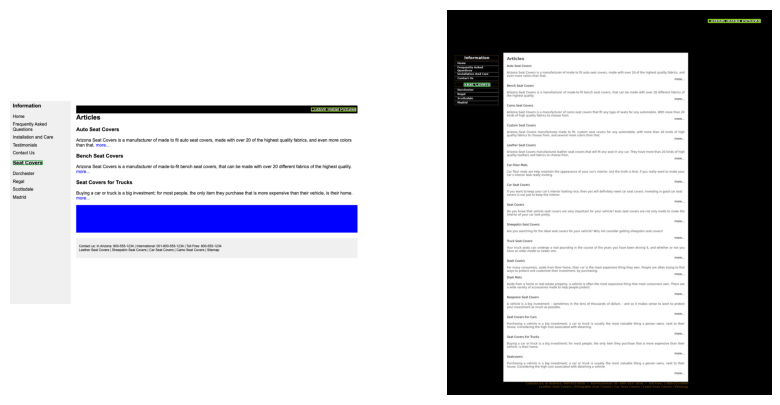

9%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3263.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3263.png', 7, 0.17308462077231865, 2.8976824672725723]


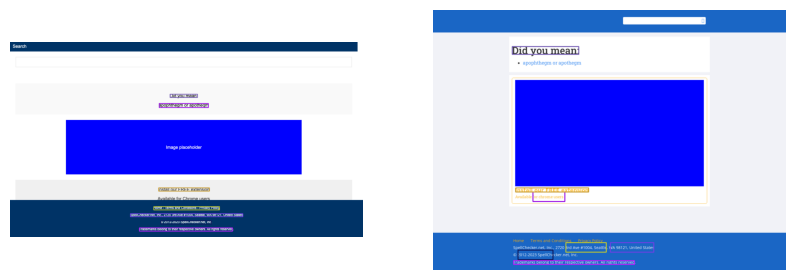

20%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_2301.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/2301.png', 21, 0.2224265219163561, 2.2074967115883486]


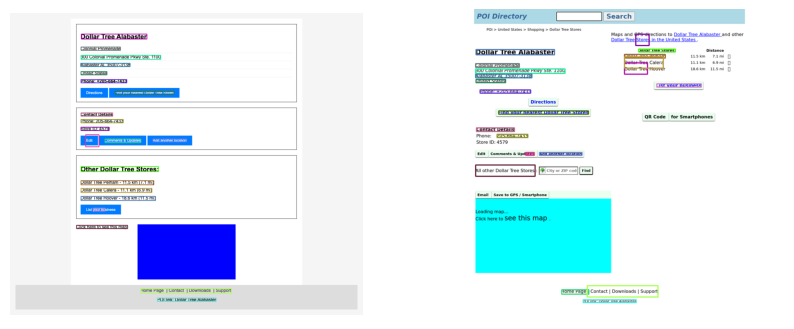

29%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1280.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1280.png', 23, 0.2440553182598683, 4.005774549114713]


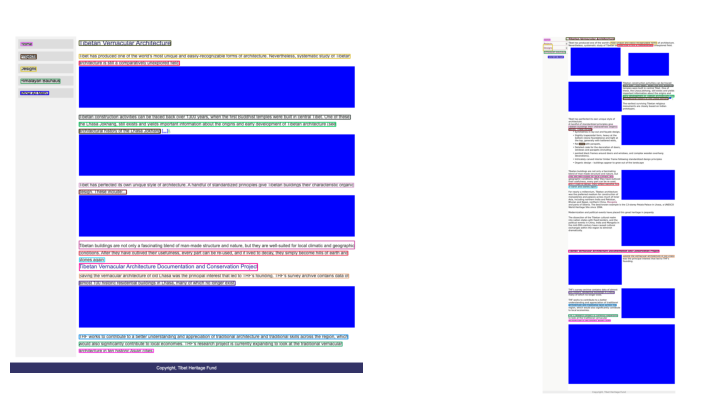

40%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_891.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/891.png', 31, 0.26770050704482146, 4.7100473958706]


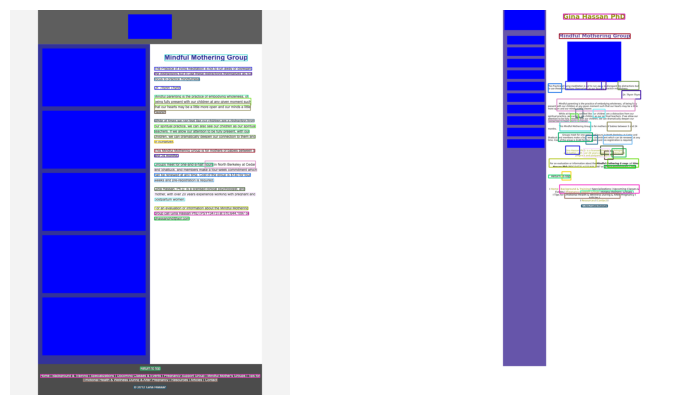

50%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1929.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1929.png', 10, 0.3199277696971458, 3.097868913076317]


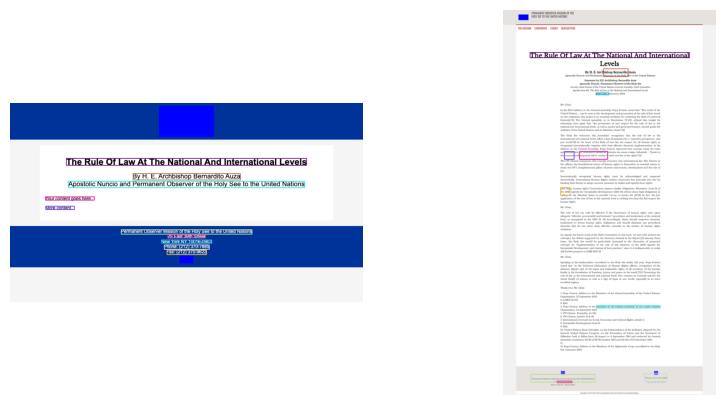

59%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_2562.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/2562.png', 11, 0.3546103699784337, 3.024615748594396]


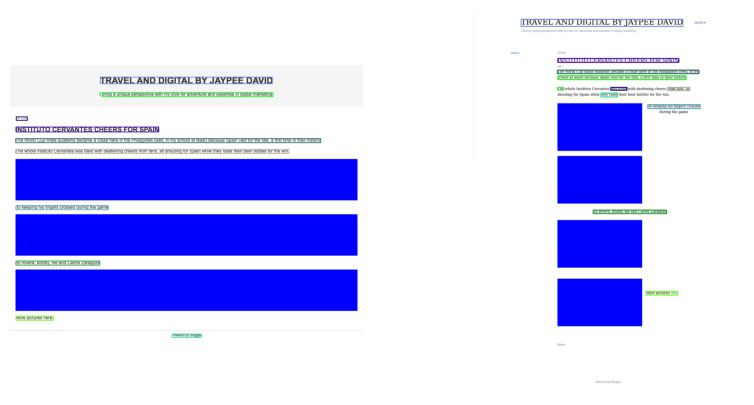

70%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_506.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/506.png', 14, 0.4036616166166994, 3.8637655886335143]


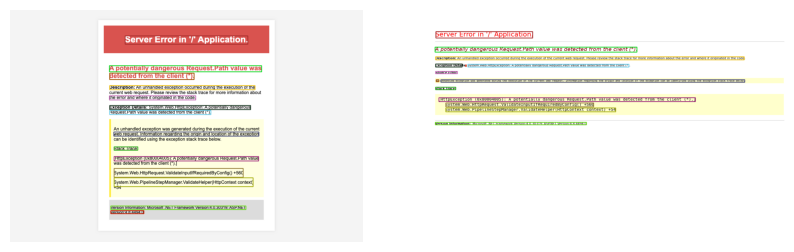

79%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4666.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4666.png', 23, 0.44431839870821516, 7.934314112226208]


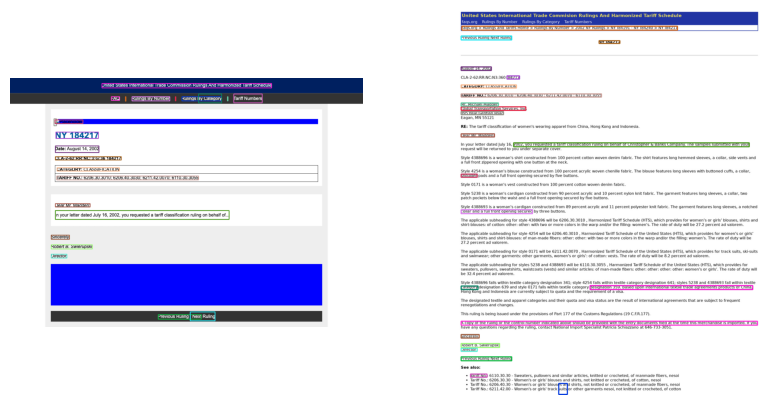

90%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3321.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3321.png', 15, 0.5003612418109601, 4.577038820237678]


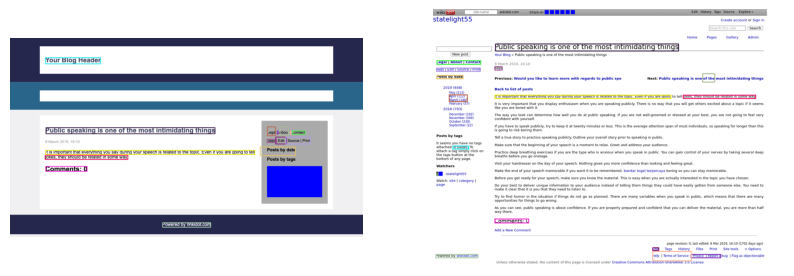

100%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4377.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4377.png', 12, 0.6679994093693894, 3.7771569821444118]


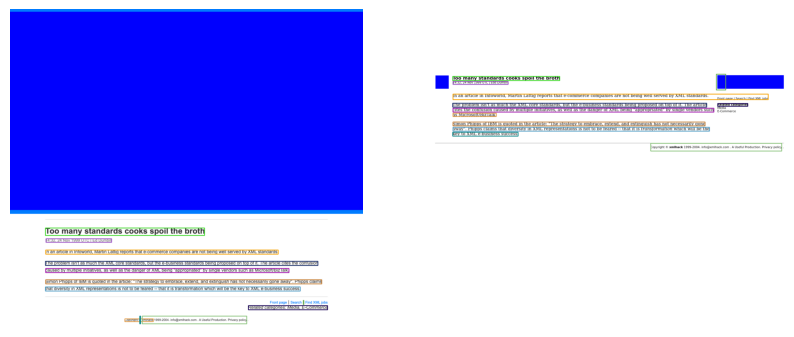

In [6]:
# Rank by location score
res_list = sorted(res_list, key=lambda tup: tup[-2])
print_percentiles(res_list)

0%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3833.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3833.png', 2, 0.20018066202897367, 1.1738698967091936]


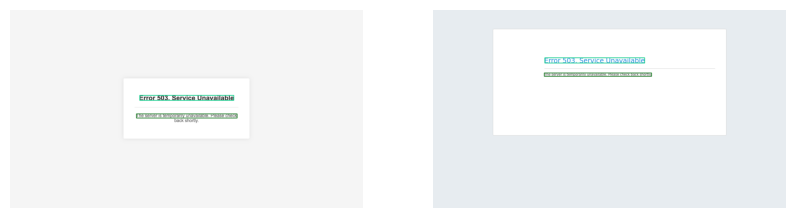

9%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4522.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4522.png', 22, 0.2287269777753787, 1.789773652782932]


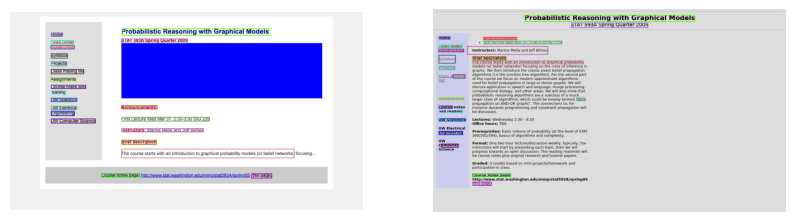

20%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4650.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4650.png', 34, 0.24793123246116644, 2.286255233342358]


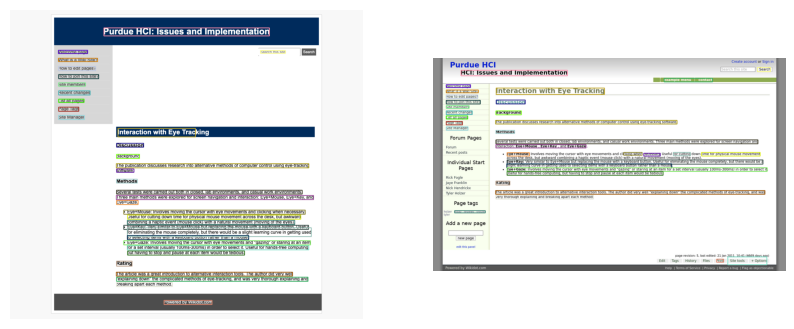

29%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_2508.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/2508.png', 54, 0.13367234078437895, 2.5313153555098475]


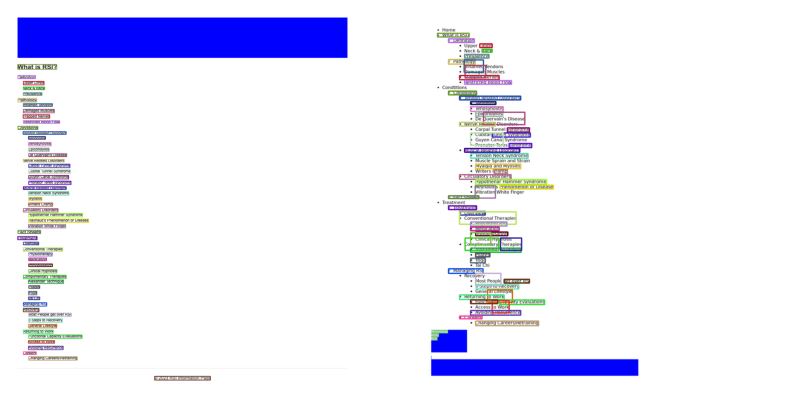

40%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_2406.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/2406.png', 33, 0.5421940500807607, 2.7704872867778207]


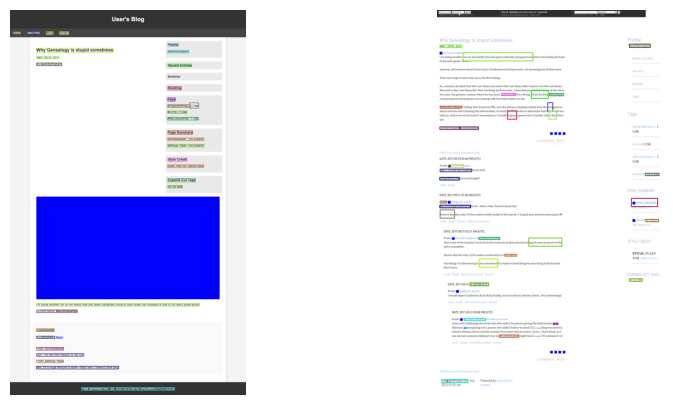

50%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1917.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1917.png', 28, 0.17712221217987642, 3.170828016303307]


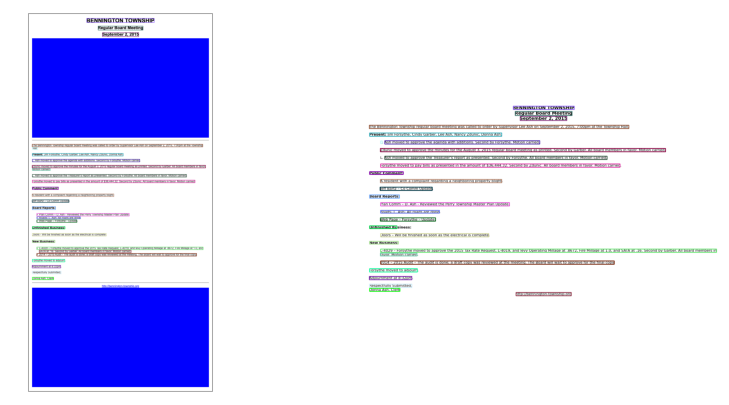

59%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4487.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4487.png', 8, 0.33016257101744517, 3.5284702202181317]


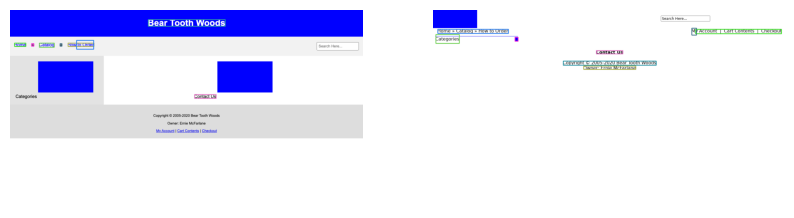

70%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1675.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1675.png', 27, 0.25090760514118693, 3.8666265241135505]


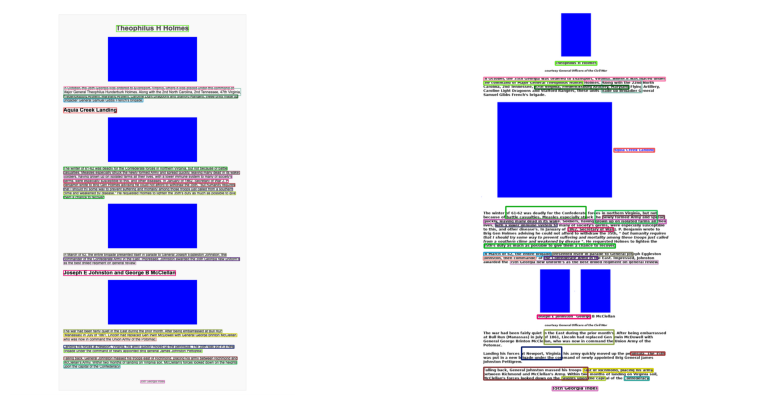

79%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_2087.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/2087.png', 20, 0.4545576749762015, 4.67909643324265]


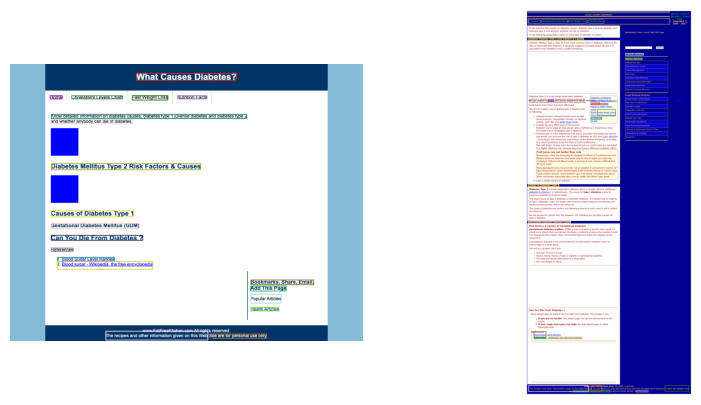

90%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1468.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1468.png', 9, 0.33093614141390065, 5.278645468015636]


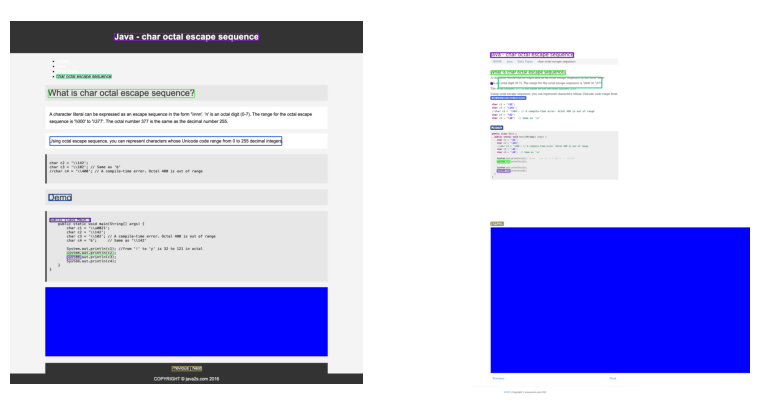

100%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4745.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4745.png', 5, 0.29987085556094334, 17.283861993187088]


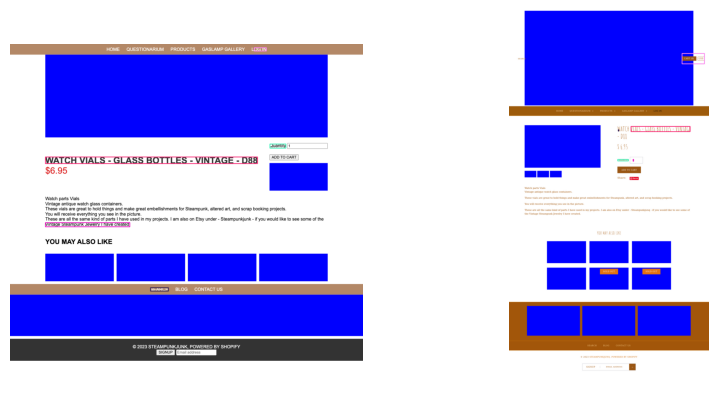

In [7]:
# Rank by size score
res_list = sorted(res_list, key=lambda tup: tup[-1])
print_percentiles(res_list)